<a href="https://colab.research.google.com/github/gireesh66/Spoken-Digit-recognition/blob/main/spoken_digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git


Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import random
from IPython.display import Audio, display
import keras

In [ ]:
from tensorflow.image import resize

DATASET_PATH = "free-spoken-digit-dataset/recordings"

def extract_spectrogram(file_path, n_mels=64, fixed_size=(64,64)):
    signal, sr = librosa.load(file_path, sr=8000)

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels,n_fft=256)

    # Convert to log scale
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Resize to fixed size (128x128)
    log_mel_spec_resized = resize(log_mel_spec[..., np.newaxis], fixed_size)

    return log_mel_spec_resized.numpy()

X, y = [], []
for file in os.listdir(DATASET_PATH):
    if file.endswith(".wav"):
        label = int(file.split("_")[0])  # digit
        spec = extract_spectrogram(os.path.join(DATASET_PATH, file))
        X.append(spec)
        y.append(label)

X = np.array(X)   # Now works, shape = (num_samples, 128, 128, 1)
y = to_categorical(y, num_classes=10)

print("Final dataset shape:", X.shape)


Final dataset shape: (3000, 64, 64, 1)


In [ ]:
DATASET_PATH = "free-spoken-digit-dataset/recordings"

# Create the list of all .wav files
files = [f for f in os.listdir(DATASET_PATH) if f.endswith(".wav")]

# Play 3 random clips
for i in range(3):
    f = random.choice(files)
    print("Clip:", f)
    display(Audio(os.path.join(DATASET_PATH, f)))


Clip: 7_theo_32.wav


Clip: 9_yweweler_13.wav


Clip: 8_theo_15.wav


In [ ]:
# First split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (2100, 64, 64, 1)
Validation shape: (300, 64, 64, 1)
Test shape: (600, 64, 64, 1)


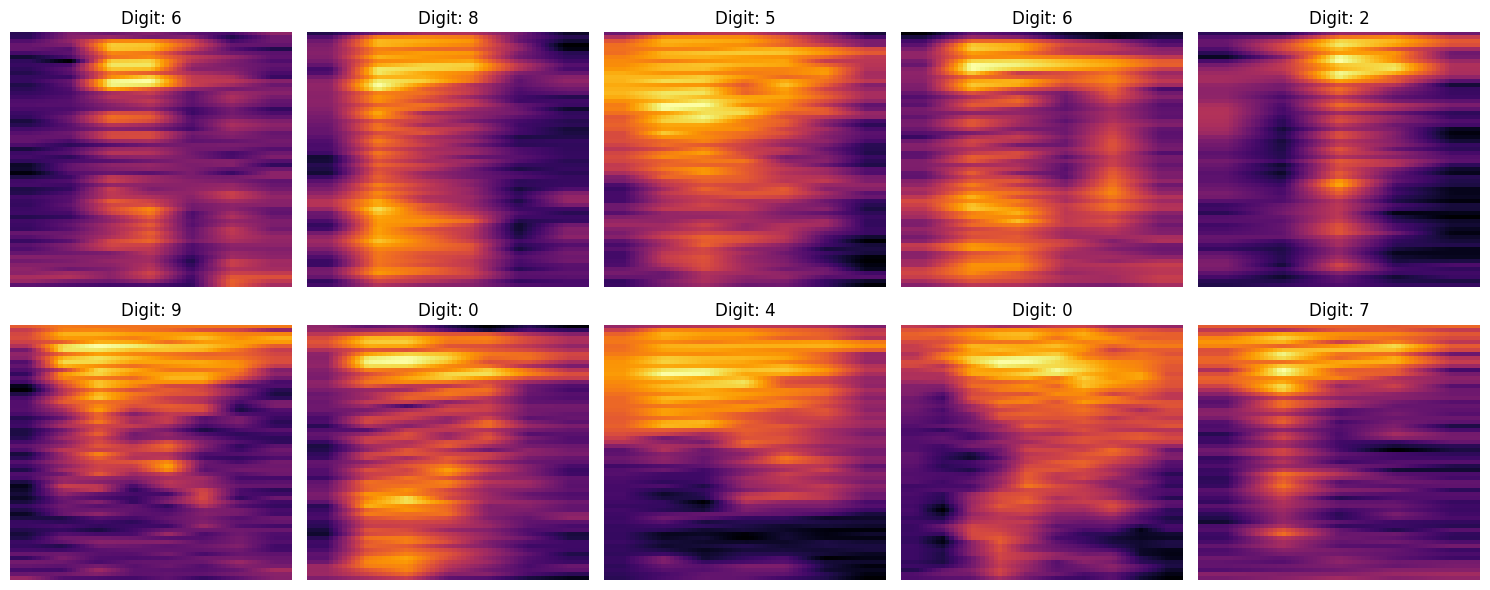

In [ ]:


# Plot 10 random spectrograms with their labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    file = random.choice(os.listdir(DATASET_PATH))
    path = os.path.join(DATASET_PATH, file)
    spec = extract_spectrogram(path)  # returns resized (128,128,1)

    ax.imshow(spec.squeeze(), cmap="inferno", aspect="auto")
    ax.set_title(f"Digit: {file.split('_')[0]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D((2,2)),

    #tf.keras.layers.LayerNormalization(axis=[-1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.1),

    #tf.keras.layers.LayerNormalization(axis=[-1]),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    #tf.keras.layers.LayerNormalization(axis=[-1]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])


optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer= optimizer,loss='categorical_crossentropy', metrics=['accuracy'],)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,042 (2.61 MB)

 Trainable params: 683,978 (2.61 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=40, batch_size=16, validation_data=(X_test, y_test),)

loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


Epoch 1/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.3167 - loss: 1.9929 - val_accuracy: 0.5283 - val_loss: 1.3591
Epoch 2/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7196 - loss: 0.8441 - val_accuracy: 0.8450 - val_loss: 0.5537
Epoch 3/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8409 - loss: 0.5028 - val_accuracy: 0.9067 - val_loss: 0.3765
Epoch 4/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8789 - loss: 0.3421 - val_accuracy: 0.9400 - val_loss: 0.2437
Epoch 5/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9003 - loss: 0.3128 - val_accuracy: 0.9383 - val_loss: 0.1958
Epoch 6/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9090 - loss: 0.2447 - val_accuracy: 0.9467 - val_loss: 0.1709
Epoch 7/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9380 - loss: 0.1855 - val_accuracy: 0.9533 - val_loss: 0.1559
Epoch 8/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9496 - loss: 0.1571 - val_accuracy: 

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9625 - loss: 0.0957 
Test Accuracy: 0.97


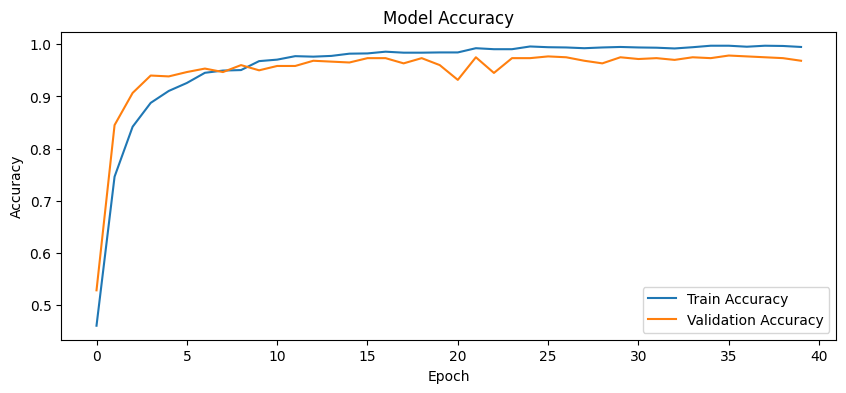

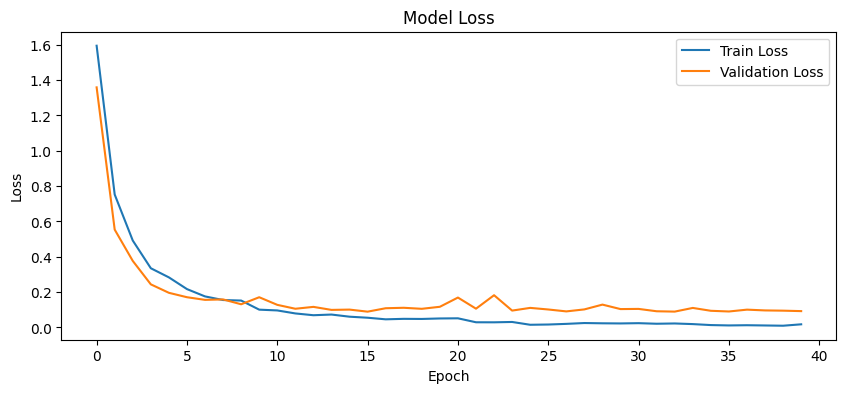

In [ ]:
# Accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
y_pred = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [ ]:
print(y_pred[0])

[2.4324964e-09 5.8700657e-06 1.1878704e-11 3.6108675e-11 7.2848194e-12
 9.9932212e-01 4.6708844e-15 1.4100077e-10 3.1878011e-11 6.7195646e-04]


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)


In [ ]:
print(y_pred[0])
print(y_pred.shape)

tf.Tensor(5, shape=(), dtype=int64)
(600,)


In [ ]:
X_testds = tf.data.Dataset.from_tensor_slices((X_test,y_test) )
y_true = tf.concat(list(X_testds.map(lambda s,label: label)), axis=0)

In [ ]:
y_true.shape


TensorShape([6000])

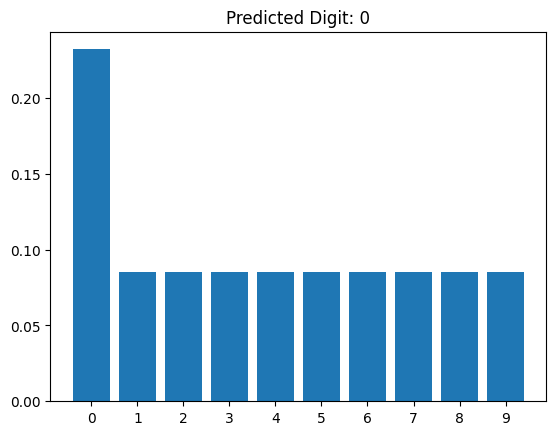

In [ ]:

testdata = 'free-spoken-digit-dataset/recordings/my_digit_0.wav'
x = tf.io.read_file(testdata)

x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
x = tf.squeeze(x, axis=-1)
waveform = x.numpy()
spec = extract_spectrogram(testdata)
spec = spec[tf.newaxis, ...]
prediction = model(spec)
x_labels = [str(i) for i in range(10)]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title(f"Predicted Digit: {np.argmax(prediction)}")
plt.show()









In [ ]:
from IPython.display import Audio, display

# Play audio
display(Audio(waveform, rate=22050))


